In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

import warnings
warnings.filterwarnings('ignore')

import util

#### Basic Visualization

In [75]:
import initial_db as db

full_df = db.get_data("A3-66")

Text(0.5, 1.0, '\nTime Series of Indoor Room Temperature (F)')

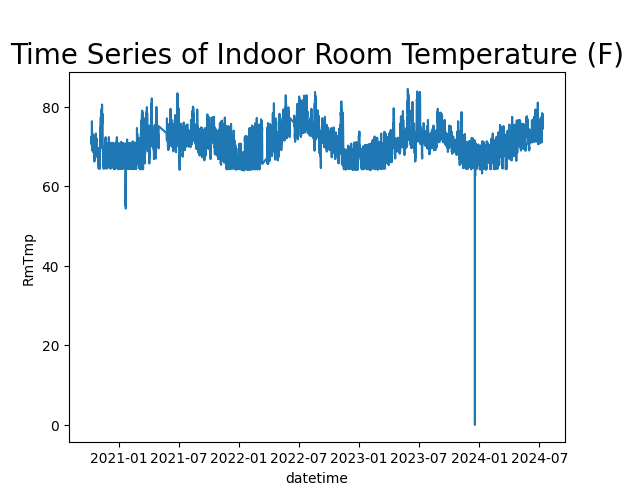

In [76]:
ax = sns.lineplot(data=full_df, x="datetime", y="RmTmp")
ax.axes.set_title("\nTime Series of Indoor Room Temperature (F)", fontsize=20)

Text(0.5, 1.0, '\nTime Series of Indoor Room Temperature (F)')

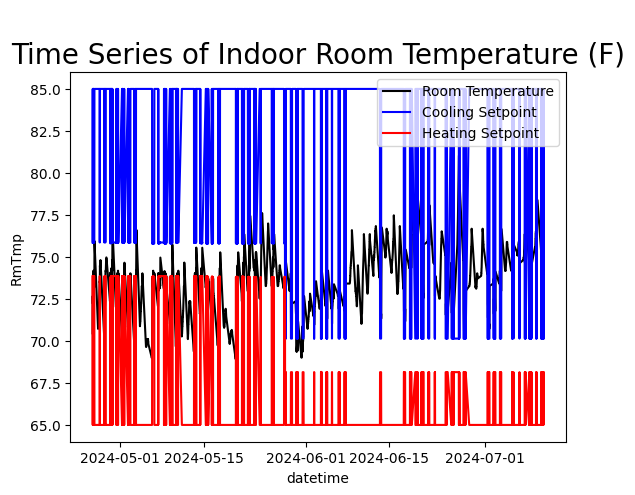

In [77]:
ax = sns.lineplot(data=full_df[51000:55000], x="datetime", y="RmTmp", color="black", label="Room Temperature")
sns.lineplot(data=full_df[51000:55000], x="datetime", y="RmTmpCspt", color="blue", label="Cooling Setpoint")
sns.lineplot(data=full_df[51000:55000], x="datetime", y="RmTmpHpst", color="red", label="Heating Setpoint")
ax.legend()
sns.move_legend(ax, "upper right")
ax.axes.set_title("\nTime Series of Indoor Room Temperature (F)", fontsize=20)

Plotting the setpoint changes, we see that often times they are at the maximum values, which is usually meant to be times when the room is unoccupied. We can filter out these to find the times when the temperature is unbounded and focus on just the spikes.

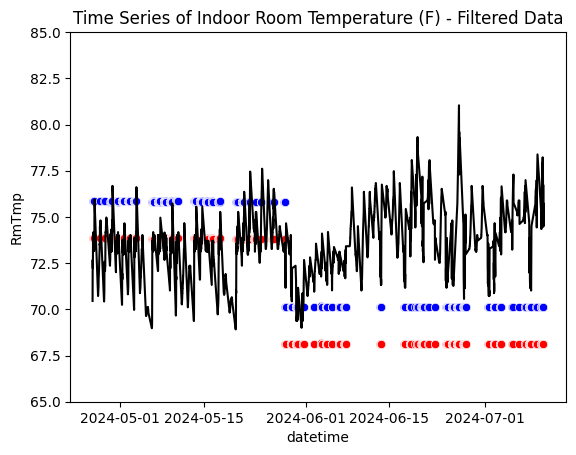

In [78]:
df_filtered = util.filter_setpoint(full_df[51000:55000])

plt.title("Time Series of Indoor Room Temperature (F) - Filtered Data")
plt.ylim((65, 85))
ax = util.graph_df_temp(full_df[51000:55000], df_filtered)


Taking each of these instances, we can plot them to see what the time to heat up to stability is

In [79]:
def filter_setpoint(df):
    """
    Filter data so that only points where the data is in between the high and low thresholds is
    kept. This runs on the assumption that unoccupied rooms usually end up at one of the extremes

    Args:
        df (pd.DataFrame): dataframe containing data to filter

    Returns (pd.DataFrame) with only rows that are "occupied"
    """
    if df is None or df.empty:
        return pd.DataFrame()

    top_threshold = max(df["RmTmpCspt"])
    bottom_threshold = df["RmTmpHpst"].value_counts().idxmax()  # min(df["RmTmpHpst"])
    df_filtered = df[df["RmTmpCspt"] < top_threshold]
    df_filtered = df_filtered.loc[df["RmTmpHpst"] > bottom_threshold]
    return df_filtered


df_filtered = filter_setpoint(full_df)
filtered_df = util.split_by_occupancy(df_filtered, full_df)
agg_df = util.remove_asymptotes(filtered_df, full_df)

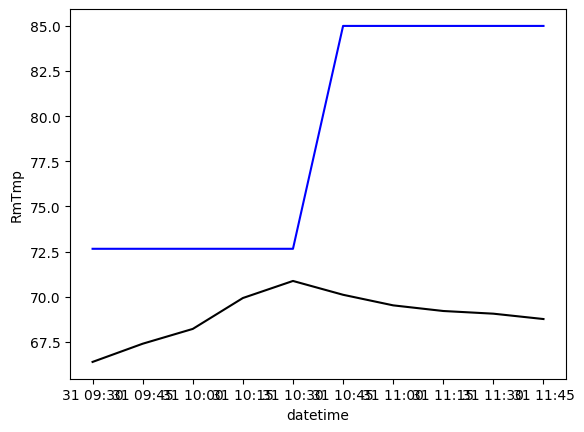

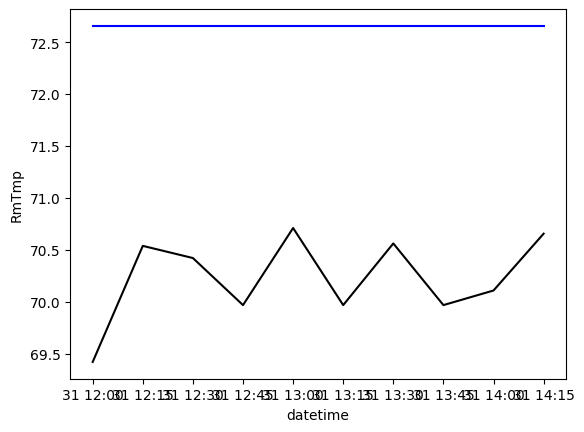

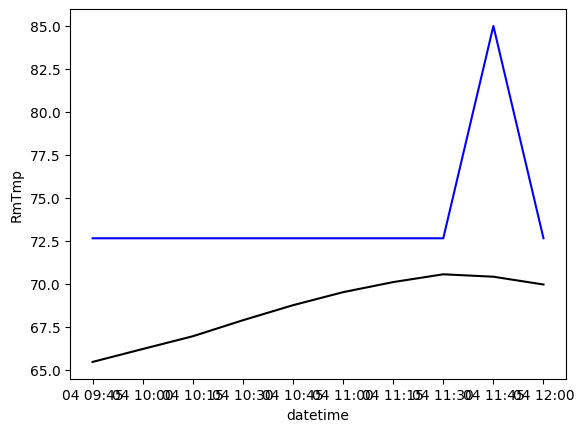

In [ ]:
def graph_agg_data(df, full_df):
    list_of_df = [d for _, d in df.groupby(df.index - np.arange(len(df)))]

    for new_df in list_of_df:
        if len(new_df) > 3:
            if (new_df.head(1)["RmTmp"] >= (new_df.head(1)["RmTmpCspt"] + 3)).all() or (new_df.head(1)["RmTmp"] <= (new_df.head(1)["RmTmpCspt"] - 3)).all():
                start_idx = new_df.index[0]

                # room_goal_temp = new_df.loc[start_idx]["RmTmpCspt"]
                # new_df["TempDiff"] = abs(new_df.RmTmp - room_goal_temp)

                # end_idxes = new_df[new_df.TempDiff <= 2.5].index
                # if len(end_idxes) == 0:
                #     continue
                # end_idx = end_idxes[0] + 1
                # this_data = new_df.loc[range(start_idx, end_idx)]

                plt.ax = sns.lineplot(data=full_df[start_idx:start_idx+10], x="datetime", y="RmTmp", color="black")
                sns.lineplot(data=full_df[start_idx:start_idx+10], x="datetime", y="RmTmpCspt", color="blue")
                plt.show()

graph_agg_data(df_filtered[1500:1550], full_df)

As seen in these graphs, the temperature (in black) generally tries to reach the cooling setpoint value whenever the room is occupied. However, oftentimes the room ends up getting unoccupied before it can reach the value and so it begins reverting back to its original state.

#### Downsampling
Smooth out data to remove hourly fluctuations and see more seasonal changes. From here, we can see
that there is a cycle that occurs  yearly basis. 

Text(0.5, 1.0, '\nAggregated Daily Temperature (F)')

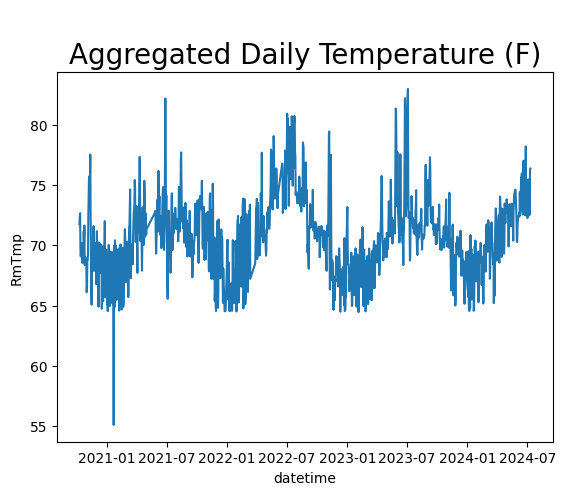

In [85]:
downsample_df = full_df.resample(rule="D", on="datetime").mean()
ax = sns.lineplot(data=downsample_df, x="datetime", y="RmTmp")
ax.axes.set_title("\nAggregated Daily Temperature (F)", fontsize=20)

#### Check for Stationary Data
Some models assume that the data is stationary, meaning that there is a constant mean (not time-dependent), constant variance (not time-dependent), and constant covariance (not time-dependent). We can try to check for this visually.

<AxesSubplot:xlabel='datetime', ylabel='RmTmp'>

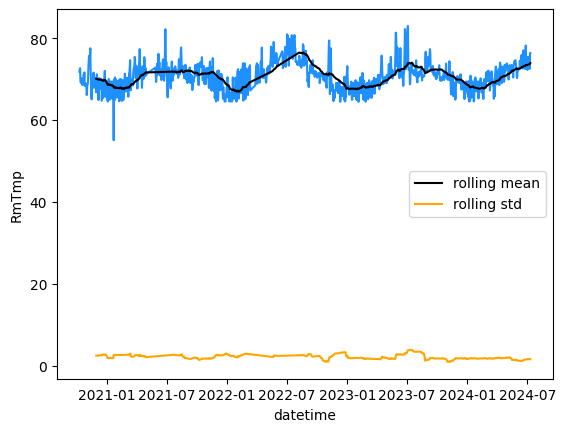

In [86]:
from pandas.plotting import autocorrelation_plot

rolling_window = 52 # 52 weeks per year

sns.lineplot(x=downsample_df.index, y=downsample_df["RmTmp"], color="dodgerblue")
sns.lineplot(x=downsample_df.index, y=downsample_df["RmTmp"].rolling(rolling_window).mean(), color="black", label="rolling mean")
sns.lineplot(x=downsample_df.index, y=downsample_df["RmTmp"].rolling(rolling_window).std(), color="orange", label="rolling std")

ADF (Augmented Dickery-Fuller) test (null hypothesis is that the time series has a unit root (is not stationary). any p-value less than 0.05 means we can reject this and that the series IS stationary.)

In [87]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(full_df["RmTmp"].values, autolag="AIC")
print(f"ADF Statistic Value: {result[0]}")
print(f"p-value: {result[1]}")
print("Critical Values:")
for key, value in result[4].items():
    print(f"    {key}: {value}")

ADF Statistic Value: -13.535280610172967
p-value: 2.574822694925771e-25
Critical Values:
    1%: -3.430470962775221
    5%: -2.8615934631509488
    10%: -2.5667984566516453


#### Correlation of Each Variable
Check if there is any correlation between different variables and the room temperature

<AxesSubplot:xlabel='RmTmp', ylabel='SaFl'>

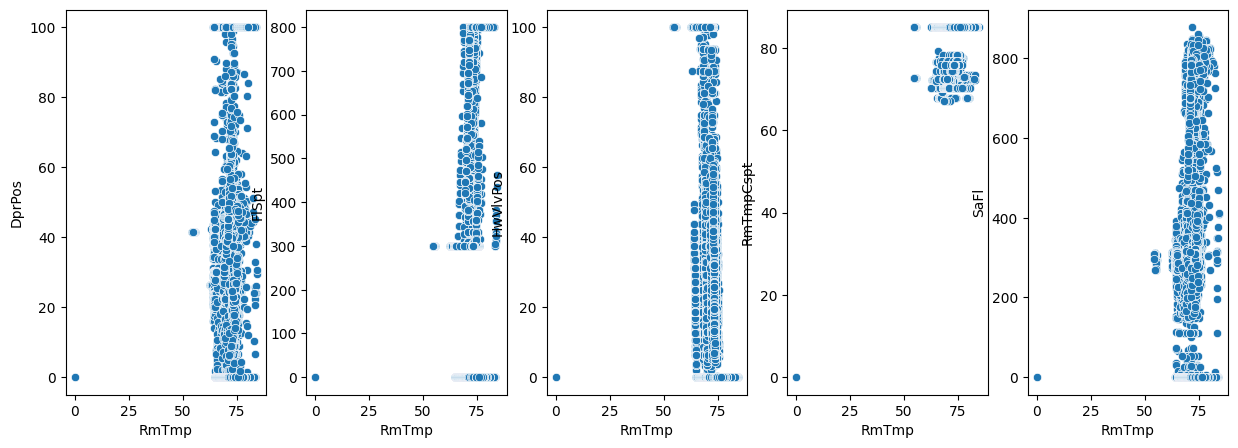

In [88]:
fig, ax = plt.subplots(1, 5, figsize=(15, 5))
sns.scatterplot(ax=ax[0], data=full_df, x="RmTmp", y="DprPos")
sns.scatterplot(ax=ax[1], data=full_df, x="RmTmp", y="FlSpt")
sns.scatterplot(ax=ax[2], data=full_df, x="RmTmp", y="HwVlvPos")
sns.scatterplot(ax=ax[3], data=full_df, x="RmTmp", y="RmTmpCspt")
sns.scatterplot(ax=ax[4], data=full_df, x="RmTmp", y="SaFl")